<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=d7e9bdf7b245fe8f76aaa61df6495618c51b79680b3b6f054563a00bf901a8e9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=480609a83132796011107f03f89784879d3fb48146f6de9b3f041f184a350760
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:06<00:00, 18.8MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [3]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [27]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 50
    batch_size = 16
    learning_rate = 1e-4
    momentum = 0.9
    weight_decay = 1.5e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [28]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [29]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [30]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [8]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 241MB/s]


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

Unet_model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
Unet_model = Unet_model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

##5.6 Res50-YNET

In [43]:
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize weights
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x5, [x0, x1, x2, x3, x4]
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )


    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)  # Corrected here
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze
        y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        # Excitation
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y
class YNetResNet34_Attention(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_Attention, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=5)
        self.bottleneck2 = Bottleneck(512, num_layers=5)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output

model = YNetResNet34_Attention(num_classes=1, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##5.7 Attention-Res-YNet

In [31]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        reduced_channels = max(1, in_channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
# Encoder with ResNet34 backbone
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)   # [B, 64, H/2, W/2]
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)  # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)   # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)   # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)   # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)   # [B, 512, H/32, W/32]
        return x5, [x0, x1, x2, x3, x4]
# Bottleneck with CBAM
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=4):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                CBAM(in_channels)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
# Decoder with CBAM
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            CBAM(out_channels)
        )

    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output
# Complete YNet with ResNet34 and CBAM
class YNetResNet34_CBAM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_CBAM, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=4)
        self.bottleneck2 = Bottleneck(512, num_layers=4)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output
model = YNetResNet34_CBAM(num_classes=config.num_classes, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#6. Training and testing

In [32]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 20:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 20 <= epoch < 30:
        return 0.5
    elif 30 <= epoch < 40:
        return 0.25
    #elif 50 <= epoch < 70:
        #return 0.1
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)
import torch.nn.functional as F

def boundary_loss(y_pred, y_true):
    # Ensure y_pred and y_true have the same number of channels
    assert y_pred.shape == y_true.shape, "Mismatch in shape"

    # Sobel filters
    sobel_kernel = torch.tensor([[[-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]],
                                 [[-1, -2, -1],
                                  [0, 0, 0],
                                  [1, 2, 1]]], dtype=torch.float32).to(y_pred.device)  # Shape: [2, 3, 3]
    sobel_kernel = sobel_kernel.unsqueeze(1)  # Shape: [2, 1, 3, 3]

    # Stack predictions and ground truths
    y_pred = torch.sigmoid(y_pred)  # Ensure y_pred is between 0 and 1
    y_true = y_true.float()

    # Compute gradients
    y_pred_grad = F.conv2d(y_pred, sobel_kernel, padding=1)
    y_true_grad = F.conv2d(y_true, sobel_kernel, padding=1)

    # Compute gradient magnitudes
    y_pred_grad_mag = torch.sqrt(y_pred_grad[:, 0] ** 2 + y_pred_grad[:, 1] ** 2 + 1e-7)
    y_true_grad_mag = torch.sqrt(y_true_grad[:, 0] ** 2 + y_true_grad[:, 1] ** 2 + 1e-7)

    # Compute L1 loss
    loss = F.l1_loss(y_pred_grad_mag, y_true_grad_mag)
    return loss




class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0):#,weight_boundary =1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        #self.weight_boundary = weight_boundary

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        #boundary = boundary_loss(probs, targets)
        return self.weight_bce*bce_loss + self.weight_dice*dice_loss #+ self.weight_boundary*boundary
# BCE + DICE
criterion = CombinedLoss(weight_bce=0, weight_dice=1.0)#,weight_boundary=1.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [33]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 1/50, Training Loss: 0.5734


Epoch 1/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 1/50, Validation Loss: 0.6023
Precision: 0.3201, Recall: 1.0000, Accuracy: 0.3201
IoU: 0.3176, F1 Score: 0.4850, Dice Coefficient: 0.4780
Pixel Error: 0.6799, Rand Error: 1.0000


Epoch 2/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


Epoch 2/50, Training Loss: 0.5682


Epoch 2/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


Epoch 2/50, Validation Loss: 0.6002
Precision: 0.3203, Recall: 0.9999, Accuracy: 0.3207
IoU: 0.3177, F1 Score: 0.4852, Dice Coefficient: 0.4782
Pixel Error: 0.6793, Rand Error: 1.0007


Epoch 3/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch 3/50, Training Loss: 0.5534


Epoch 3/50 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Epoch 3/50, Validation Loss: 0.5658
Precision: 0.4110, Recall: 0.9519, Accuracy: 0.5479
IoU: 0.4021, F1 Score: 0.5741, Dice Coefficient: 0.5675
Pixel Error: 0.4521, Rand Error: 0.9977


Epoch 4/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 4/50, Training Loss: 0.5042


Epoch 4/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


Epoch 4/50, Validation Loss: 0.4302
Precision: 0.7379, Recall: 0.9843, Accuracy: 0.8830
IoU: 0.7206, F1 Score: 0.8435, Dice Coefficient: 0.8360
Pixel Error: 0.1170, Rand Error: 0.4178


Epoch 5/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 5/50, Training Loss: 0.4743


Epoch 5/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


Epoch 5/50, Validation Loss: 0.4796
Precision: 0.7715, Recall: 0.9859, Accuracy: 0.9020
IoU: 0.7583, F1 Score: 0.8656, Dice Coefficient: 0.8619
Pixel Error: 0.0980, Rand Error: 0.3574


Epoch 6/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 6/50, Training Loss: 0.4585


Epoch 6/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 6/50, Validation Loss: 0.5082
Precision: 0.7762, Recall: 0.9960, Accuracy: 0.9068
IoU: 0.7647, F1 Score: 0.8725, Dice Coefficient: 0.8653
Pixel Error: 0.0932, Rand Error: 0.3439


Epoch 7/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 7/50, Training Loss: 0.4440


Epoch 7/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 7/50, Validation Loss: 0.4922
Precision: 0.7879, Recall: 0.9909, Accuracy: 0.9117
IoU: 0.7752, F1 Score: 0.8778, Dice Coefficient: 0.8721
Pixel Error: 0.0883, Rand Error: 0.3270


Epoch 8/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 8/50, Training Loss: 0.4334


Epoch 8/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


Epoch 8/50, Validation Loss: 0.4820
Precision: 0.8186, Recall: 0.9907, Accuracy: 0.9267
IoU: 0.8064, F1 Score: 0.8965, Dice Coefficient: 0.8921
Pixel Error: 0.0733, Rand Error: 0.2764


Epoch 9/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 9/50, Training Loss: 0.4231


Epoch 9/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


Epoch 9/50, Validation Loss: 0.4636
Precision: 0.8361, Recall: 0.9884, Accuracy: 0.9342
IoU: 0.8230, F1 Score: 0.9059, Dice Coefficient: 0.9024
Pixel Error: 0.0658, Rand Error: 0.2504


Epoch 10/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 10/50, Training Loss: 0.4162


Epoch 10/50 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Epoch 10/50, Validation Loss: 0.4473
Precision: 0.8251, Recall: 0.9922, Accuracy: 0.9302
IoU: 0.8143, F1 Score: 0.9010, Dice Coefficient: 0.8971
Pixel Error: 0.0698, Rand Error: 0.2644


Epoch 11/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 11/50, Training Loss: 0.4094


Epoch 11/50 - Validation: 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


Epoch 11/50, Validation Loss: 0.4611
Precision: 0.8767, Recall: 0.9710, Accuracy: 0.9470
IoU: 0.8520, F1 Score: 0.9214, Dice Coefficient: 0.9197
Pixel Error: 0.0530, Rand Error: 0.2045


Epoch 12/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 12/50, Training Loss: 0.4008


Epoch 12/50 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Epoch 12/50, Validation Loss: 0.4455
Precision: 0.8598, Recall: 0.9860, Accuracy: 0.9440
IoU: 0.8448, F1 Score: 0.9185, Dice Coefficient: 0.9155
Pixel Error: 0.0560, Rand Error: 0.2157


Epoch 13/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 13/50, Training Loss: 0.3961


Epoch 13/50 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.67s/it]


Epoch 13/50, Validation Loss: 0.4350
Precision: 0.8767, Recall: 0.9853, Accuracy: 0.9509
IoU: 0.8604, F1 Score: 0.9278, Dice Coefficient: 0.9246
Pixel Error: 0.0491, Rand Error: 0.1913


Epoch 14/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 14/50, Training Loss: 0.3877


Epoch 14/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Epoch 14/50, Validation Loss: 0.4284
Precision: 0.8336, Recall: 0.9846, Accuracy: 0.9322
IoU: 0.8167, F1 Score: 0.9029, Dice Coefficient: 0.8983
Pixel Error: 0.0678, Rand Error: 0.2582


Epoch 15/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 15/50, Training Loss: 0.3873


Epoch 15/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


Epoch 15/50, Validation Loss: 0.4262
Precision: 0.8802, Recall: 0.9673, Accuracy: 0.9474
IoU: 0.8522, F1 Score: 0.9217, Dice Coefficient: 0.9198
Pixel Error: 0.0526, Rand Error: 0.2037


Epoch 16/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 16/50, Training Loss: 0.3821


Epoch 16/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 16/50, Validation Loss: 0.4170
Precision: 0.8293, Recall: 0.9721, Accuracy: 0.9270
IoU: 0.8103, F1 Score: 0.8951, Dice Coefficient: 0.8950
Pixel Error: 0.0730, Rand Error: 0.2727


Epoch 17/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 17/50, Training Loss: 0.3741


Epoch 17/50 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Epoch 17/50, Validation Loss: 0.4287
Precision: 0.8921, Recall: 0.9713, Accuracy: 0.9532
IoU: 0.8673, F1 Score: 0.9300, Dice Coefficient: 0.9287
Pixel Error: 0.0468, Rand Error: 0.1822


Epoch 18/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 18/50, Training Loss: 0.3684


Epoch 18/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Epoch 18/50, Validation Loss: 0.4169
Precision: 0.8549, Recall: 0.9602, Accuracy: 0.9351
IoU: 0.8251, F1 Score: 0.9045, Dice Coefficient: 0.9039
Pixel Error: 0.0649, Rand Error: 0.2456


Epoch 19/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 19/50, Training Loss: 0.3618


Epoch 19/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Epoch 19/50, Validation Loss: 0.3917
Precision: 0.8903, Recall: 0.9831, Accuracy: 0.9558
IoU: 0.8737, F1 Score: 0.9344, Dice Coefficient: 0.9322
Pixel Error: 0.0442, Rand Error: 0.1727


Epoch 20/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 20/50, Training Loss: 0.3605


Epoch 20/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 20/50, Validation Loss: 0.4019
Precision: 0.8642, Recall: 0.9869, Accuracy: 0.9462
IoU: 0.8501, F1 Score: 0.9215, Dice Coefficient: 0.9187
Pixel Error: 0.0538, Rand Error: 0.2080


Epoch 21/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 21/50, Training Loss: 0.3567


Epoch 21/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Epoch 21/50, Validation Loss: 0.3881
Precision: 0.8633, Recall: 0.9899, Accuracy: 0.9466
IoU: 0.8513, F1 Score: 0.9223, Dice Coefficient: 0.9194
Pixel Error: 0.0534, Rand Error: 0.2064


Epoch 22/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 22/50, Training Loss: 0.3574


Epoch 22/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


Epoch 22/50, Validation Loss: 0.3824
Precision: 0.8467, Recall: 0.9950, Accuracy: 0.9407
IoU: 0.8375, F1 Score: 0.9149, Dice Coefficient: 0.9111
Pixel Error: 0.0593, Rand Error: 0.2276


Epoch 23/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 23/50, Training Loss: 0.3543


Epoch 23/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Epoch 23/50, Validation Loss: 0.3901
Precision: 0.8795, Recall: 0.9798, Accuracy: 0.9506
IoU: 0.8613, F1 Score: 0.9269, Dice Coefficient: 0.9253
Pixel Error: 0.0494, Rand Error: 0.1919


Epoch 24/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 24/50, Training Loss: 0.3513


Epoch 24/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


Epoch 24/50, Validation Loss: 0.3849
Precision: 0.8794, Recall: 0.9873, Accuracy: 0.9526
IoU: 0.8669, F1 Score: 0.9302, Dice Coefficient: 0.9284
Pixel Error: 0.0474, Rand Error: 0.1842


Epoch 25/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 25/50, Training Loss: 0.3470


Epoch 25/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Epoch 25/50, Validation Loss: 0.3798
Precision: 0.8466, Recall: 0.9945, Accuracy: 0.9406
IoU: 0.8376, F1 Score: 0.9146, Dice Coefficient: 0.9112
Pixel Error: 0.0594, Rand Error: 0.2278


Epoch 26/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 26/50, Training Loss: 0.3441


Epoch 26/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Epoch 26/50, Validation Loss: 0.3796
Precision: 0.8861, Recall: 0.9885, Accuracy: 0.9557
IoU: 0.8736, F1 Score: 0.9345, Dice Coefficient: 0.9323
Pixel Error: 0.0443, Rand Error: 0.1734


Epoch 27/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 27/50, Training Loss: 0.3434


Epoch 27/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Epoch 27/50, Validation Loss: 0.3770
Precision: 0.8844, Recall: 0.9908, Accuracy: 0.9556
IoU: 0.8734, F1 Score: 0.9346, Dice Coefficient: 0.9322
Pixel Error: 0.0444, Rand Error: 0.1737


Epoch 28/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 28/50, Training Loss: 0.3424


Epoch 28/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


Epoch 28/50, Validation Loss: 0.3802
Precision: 0.8728, Recall: 0.9914, Accuracy: 0.9510
IoU: 0.8618, F1 Score: 0.9283, Dice Coefficient: 0.9255
Pixel Error: 0.0490, Rand Error: 0.1907


Epoch 29/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 29/50, Training Loss: 0.3382


Epoch 29/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Epoch 29/50, Validation Loss: 0.3760
Precision: 0.8676, Recall: 0.9927, Accuracy: 0.9492
IoU: 0.8576, F1 Score: 0.9260, Dice Coefficient: 0.9231
Pixel Error: 0.0508, Rand Error: 0.1971


Epoch 30/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 30/50, Training Loss: 0.3352


Epoch 30/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Epoch 30/50, Validation Loss: 0.3731
Precision: 0.8943, Recall: 0.9871, Accuracy: 0.9585
IoU: 0.8808, F1 Score: 0.9384, Dice Coefficient: 0.9364
Pixel Error: 0.0415, Rand Error: 0.1628


Epoch 31/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 31/50, Training Loss: 0.3353


Epoch 31/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 31/50, Validation Loss: 0.3702
Precision: 0.8789, Recall: 0.9906, Accuracy: 0.9533
IoU: 0.8678, F1 Score: 0.9314, Dice Coefficient: 0.9290
Pixel Error: 0.0467, Rand Error: 0.1820


Epoch 32/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 32/50, Training Loss: 0.3321


Epoch 32/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 32/50, Validation Loss: 0.3675
Precision: 0.8815, Recall: 0.9908, Accuracy: 0.9544
IoU: 0.8707, F1 Score: 0.9329, Dice Coefficient: 0.9306
Pixel Error: 0.0456, Rand Error: 0.1779


Epoch 33/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 33/50, Training Loss: 0.3310


Epoch 33/50 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Epoch 33/50, Validation Loss: 0.3685
Precision: 0.8789, Recall: 0.9902, Accuracy: 0.9532
IoU: 0.8679, F1 Score: 0.9312, Dice Coefficient: 0.9290
Pixel Error: 0.0468, Rand Error: 0.1823


Epoch 34/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 34/50, Training Loss: 0.3291


Epoch 34/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 34/50, Validation Loss: 0.3643
Precision: 0.8916, Recall: 0.9902, Accuracy: 0.9583
IoU: 0.8803, F1 Score: 0.9383, Dice Coefficient: 0.9361
Pixel Error: 0.0417, Rand Error: 0.1635


Epoch 35/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 35/50, Training Loss: 0.3362


Epoch 35/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


Epoch 35/50, Validation Loss: 0.3567
Precision: 0.8547, Recall: 0.9954, Accuracy: 0.9444
IoU: 0.8461, F1 Score: 0.9197, Dice Coefficient: 0.9162
Pixel Error: 0.0556, Rand Error: 0.2146


Epoch 36/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 36/50, Training Loss: 0.3315


Epoch 36/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


Epoch 36/50, Validation Loss: 0.3678
Precision: 0.9095, Recall: 0.9794, Accuracy: 0.9622
IoU: 0.8898, F1 Score: 0.9431, Dice Coefficient: 0.9416
Pixel Error: 0.0378, Rand Error: 0.1491


Epoch 37/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 37/50, Training Loss: 0.3293


Epoch 37/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Epoch 37/50, Validation Loss: 0.3623
Precision: 0.8882, Recall: 0.9915, Accuracy: 0.9573
IoU: 0.8777, F1 Score: 0.9370, Dice Coefficient: 0.9346
Pixel Error: 0.0427, Rand Error: 0.1673


Epoch 38/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 38/50, Training Loss: 0.3297


Epoch 38/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Epoch 38/50, Validation Loss: 0.3636
Precision: 0.8759, Recall: 0.9927, Accuracy: 0.9526
IoU: 0.8661, F1 Score: 0.9306, Dice Coefficient: 0.9280
Pixel Error: 0.0474, Rand Error: 0.1845


Epoch 39/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 39/50, Training Loss: 0.3289


Epoch 39/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Epoch 39/50, Validation Loss: 0.3602
Precision: 0.8875, Recall: 0.9915, Accuracy: 0.9570
IoU: 0.8770, F1 Score: 0.9366, Dice Coefficient: 0.9343
Pixel Error: 0.0430, Rand Error: 0.1683


Epoch 40/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 40/50, Training Loss: 0.3276


Epoch 40/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Epoch 40/50, Validation Loss: 0.3611
Precision: 0.8942, Recall: 0.9902, Accuracy: 0.9594
IoU: 0.8828, F1 Score: 0.9398, Dice Coefficient: 0.9376
Pixel Error: 0.0406, Rand Error: 0.1597


Epoch 41/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 41/50, Training Loss: 0.3250


Epoch 41/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 41/50, Validation Loss: 0.3582
Precision: 0.8867, Recall: 0.9920, Accuracy: 0.9568
IoU: 0.8769, F1 Score: 0.9364, Dice Coefficient: 0.9342
Pixel Error: 0.0432, Rand Error: 0.1689


Epoch 42/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 42/50, Training Loss: 0.3208


Epoch 42/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Epoch 42/50, Validation Loss: 0.3590
Precision: 0.8918, Recall: 0.9903, Accuracy: 0.9584
IoU: 0.8809, F1 Score: 0.9385, Dice Coefficient: 0.9364
Pixel Error: 0.0416, Rand Error: 0.1630


Epoch 43/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 43/50, Training Loss: 0.3238


Epoch 43/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Epoch 43/50, Validation Loss: 0.3595
Precision: 0.8928, Recall: 0.9903, Accuracy: 0.9588
IoU: 0.8817, F1 Score: 0.9390, Dice Coefficient: 0.9369
Pixel Error: 0.0412, Rand Error: 0.1616


Epoch 44/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 44/50, Training Loss: 0.3211


Epoch 44/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Epoch 44/50, Validation Loss: 0.3574
Precision: 0.8892, Recall: 0.9911, Accuracy: 0.9576
IoU: 0.8787, F1 Score: 0.9374, Dice Coefficient: 0.9352
Pixel Error: 0.0424, Rand Error: 0.1661


Epoch 45/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 45/50, Training Loss: 0.3256


Epoch 45/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


Epoch 45/50, Validation Loss: 0.3566
Precision: 0.8902, Recall: 0.9910, Accuracy: 0.9580
IoU: 0.8797, F1 Score: 0.9379, Dice Coefficient: 0.9358
Pixel Error: 0.0420, Rand Error: 0.1647


Epoch 46/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 46/50, Training Loss: 0.3225


Epoch 46/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 46/50, Validation Loss: 0.3572
Precision: 0.8885, Recall: 0.9917, Accuracy: 0.9575
IoU: 0.8783, F1 Score: 0.9373, Dice Coefficient: 0.9350
Pixel Error: 0.0425, Rand Error: 0.1665


Epoch 47/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 47/50, Training Loss: 0.3273


Epoch 47/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 47/50, Validation Loss: 0.3539
Precision: 0.8810, Recall: 0.9920, Accuracy: 0.9545
IoU: 0.8711, F1 Score: 0.9332, Dice Coefficient: 0.9309
Pixel Error: 0.0455, Rand Error: 0.1774


Epoch 48/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 48/50, Training Loss: 0.3238


Epoch 48/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Epoch 48/50, Validation Loss: 0.3543
Precision: 0.8901, Recall: 0.9897, Accuracy: 0.9576
IoU: 0.8787, F1 Score: 0.9373, Dice Coefficient: 0.9352
Pixel Error: 0.0424, Rand Error: 0.1662


Epoch 49/50 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 49/50, Training Loss: 0.3267


Epoch 49/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Epoch 49/50, Validation Loss: 0.3570
Precision: 0.8892, Recall: 0.9900, Accuracy: 0.9573
IoU: 0.8777, F1 Score: 0.9369, Dice Coefficient: 0.9346
Pixel Error: 0.0427, Rand Error: 0.1673


Epoch 50/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 50/50, Training Loss: 0.3184


Epoch 50/50 - Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]

Epoch 50/50, Validation Loss: 0.3554
Precision: 0.8906, Recall: 0.9902, Accuracy: 0.9579
IoU: 0.8795, F1 Score: 0.9378, Dice Coefficient: 0.9357
Pixel Error: 0.0421, Rand Error: 0.1649


##6.2 Testing



In [34]:
model.eval()
test_loss = 0.0

# Initialize lists for metrics with "data_testing" prefix
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        # Calculate loss
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Threshold predictions for metrics (e.g., using 0.5 as the threshold)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        tp = (preds * masks).sum().item()  # True Positives
        fp = (preds * (1 - masks)).sum().item()  # False Positives
        fn = ((1 - preds) * masks).sum().item()  # False Negatives
        tn = ((1 - preds) * (1 - masks)).sum().item()  # True Negatives

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)

        # Append metrics to lists
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)

# Compute average test loss
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Compute average metrics
avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


Testing: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]

Test Loss: 0.3871
Average Precision: 0.8718
Average Recall: 0.9738
Average Accuracy: 0.9508
Average IoU: 0.8529
Average F1 Score: 0.9194
Average Dice Coefficient: 0.9194
Average Pixel Error: 0.0492
Average Rand Error: 0.0492


In [35]:
import pandas as pd

results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [36]:
# Save the model
torch.save(model.state_dict(), 'Ynet34-atten_model.pth')

# Load the model
model.load_state_dict(torch.load('Ynet34-atten_model.pth'))
model.eval()

<ipython-input-36-4c799bb9b1d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Ynet34-atten_model.pth'))


YNetResNet34_CBAM(
  (encoder): ResNet34Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

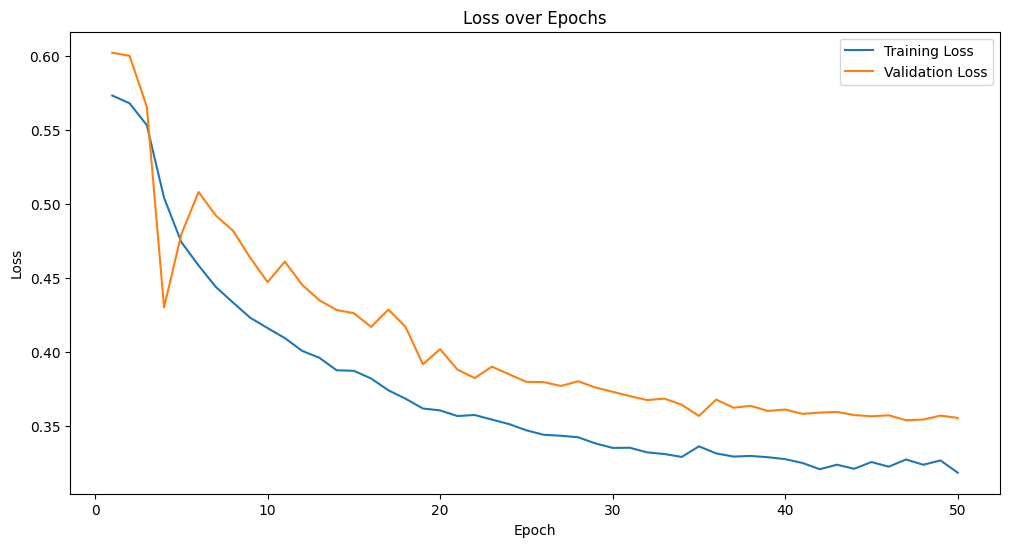

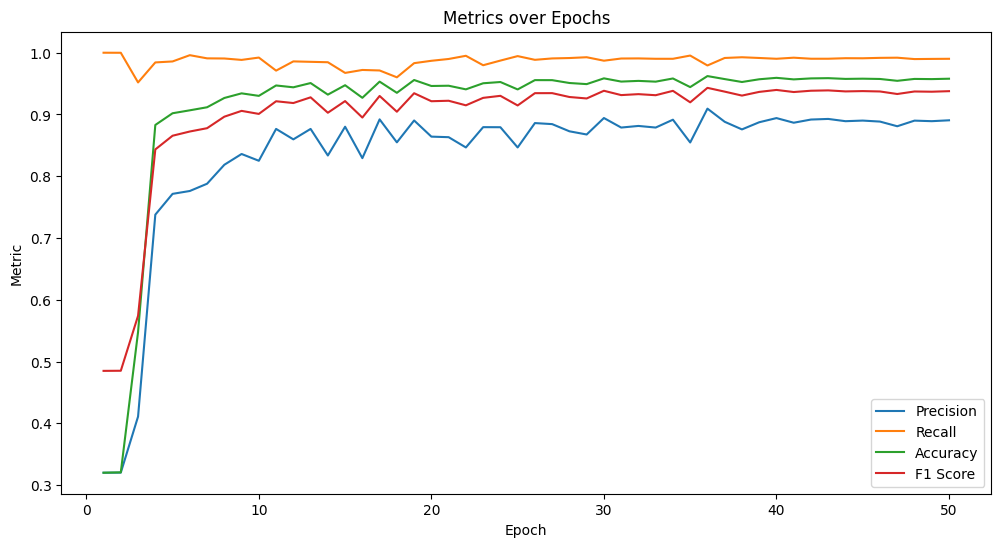

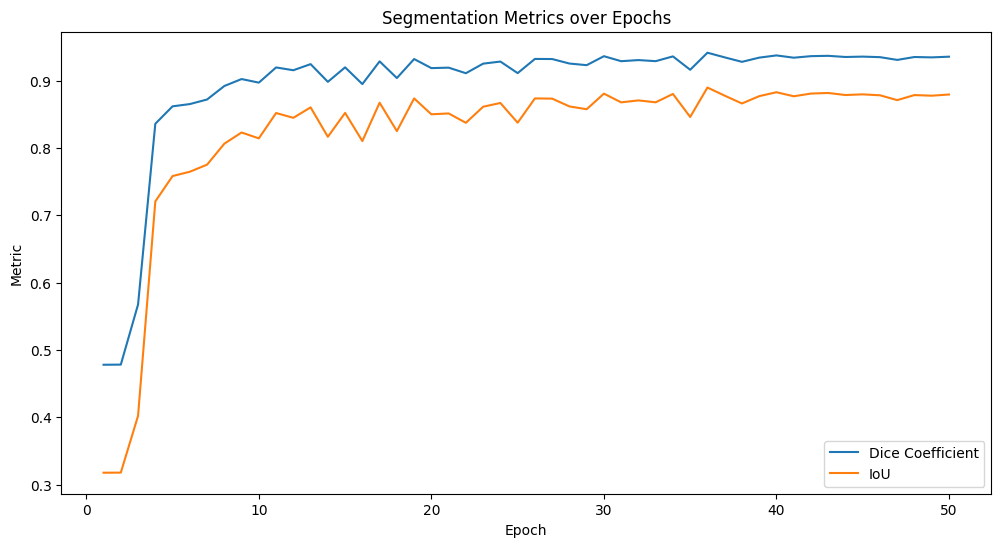

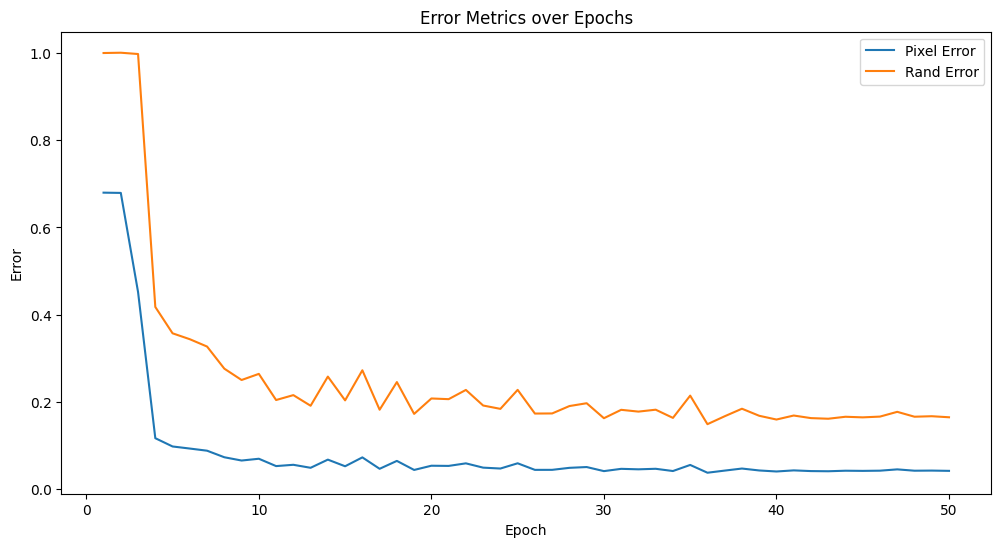

In [37]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.savefig('metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.savefig('segmentation_metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.savefig('error_metrics.png')
plt.show()



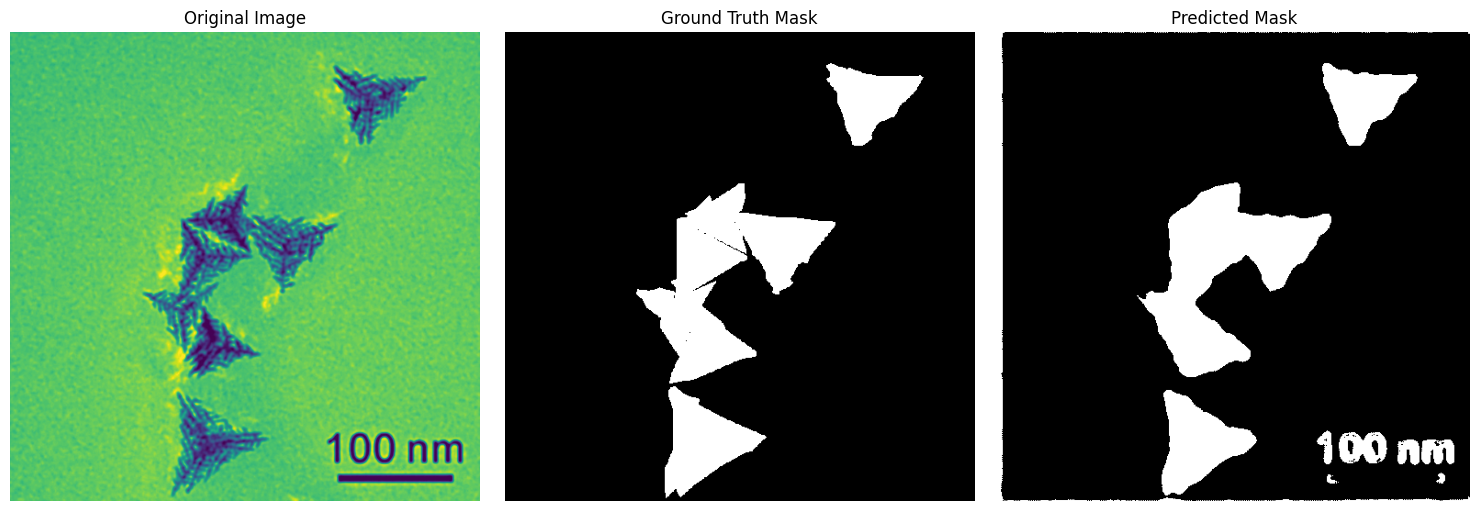

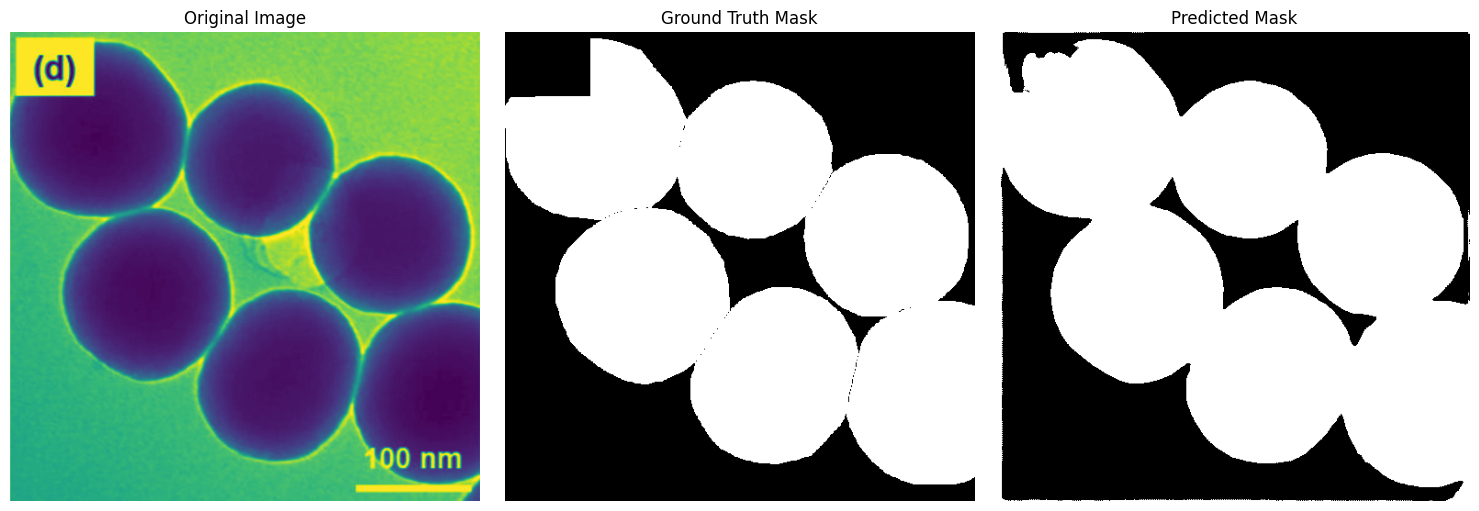

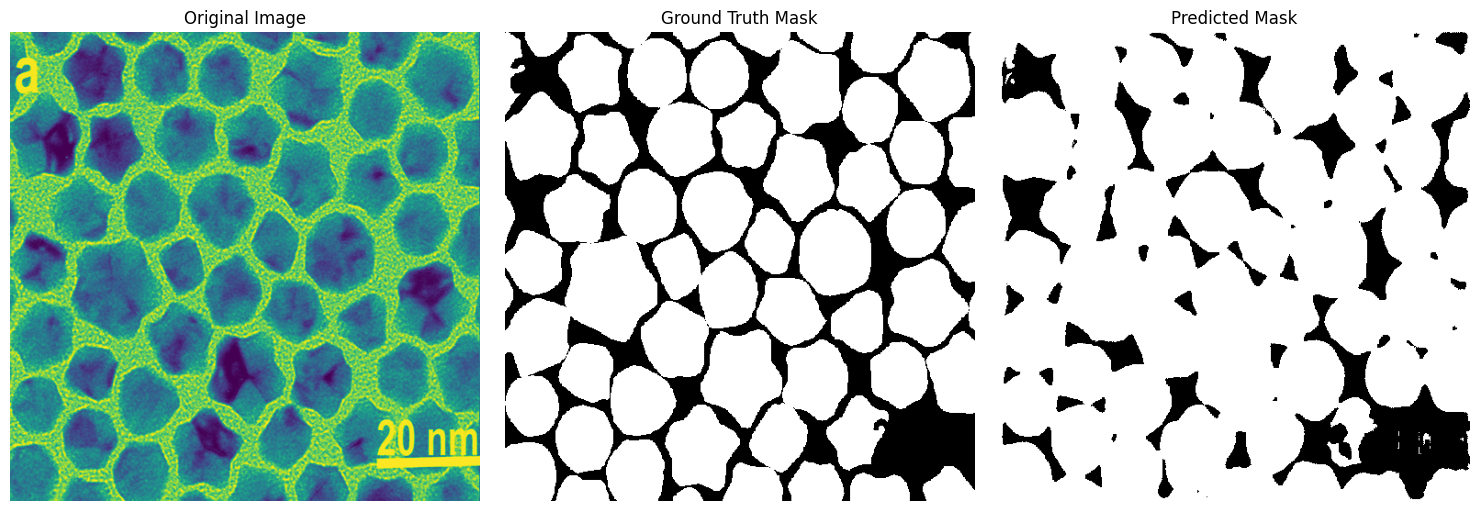

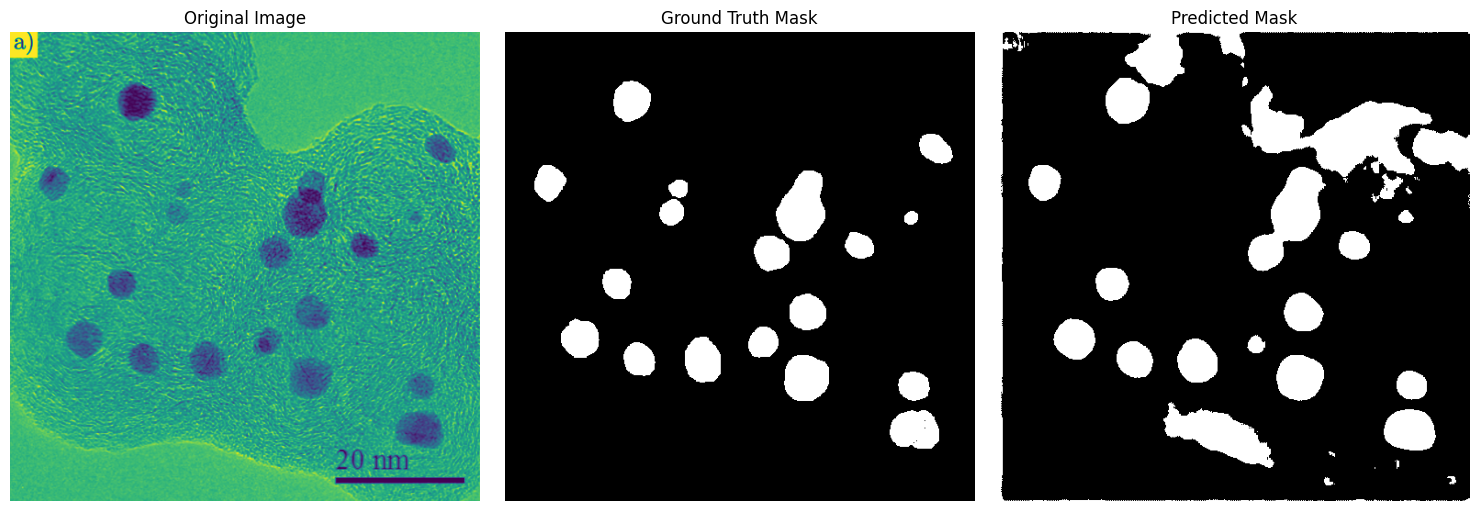

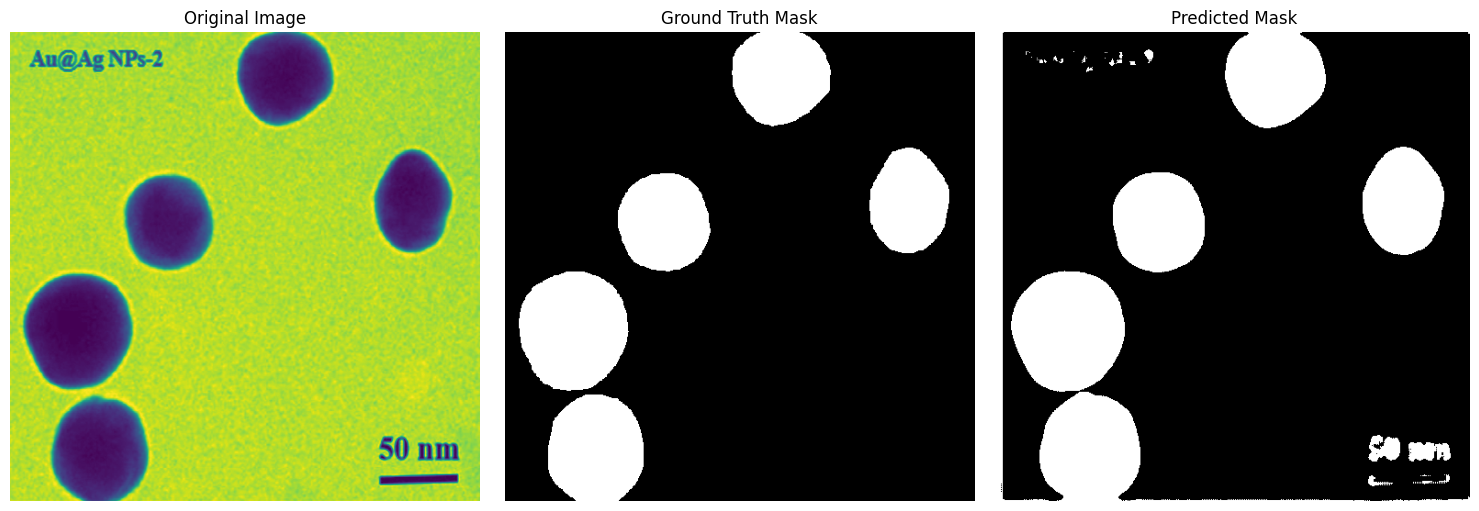

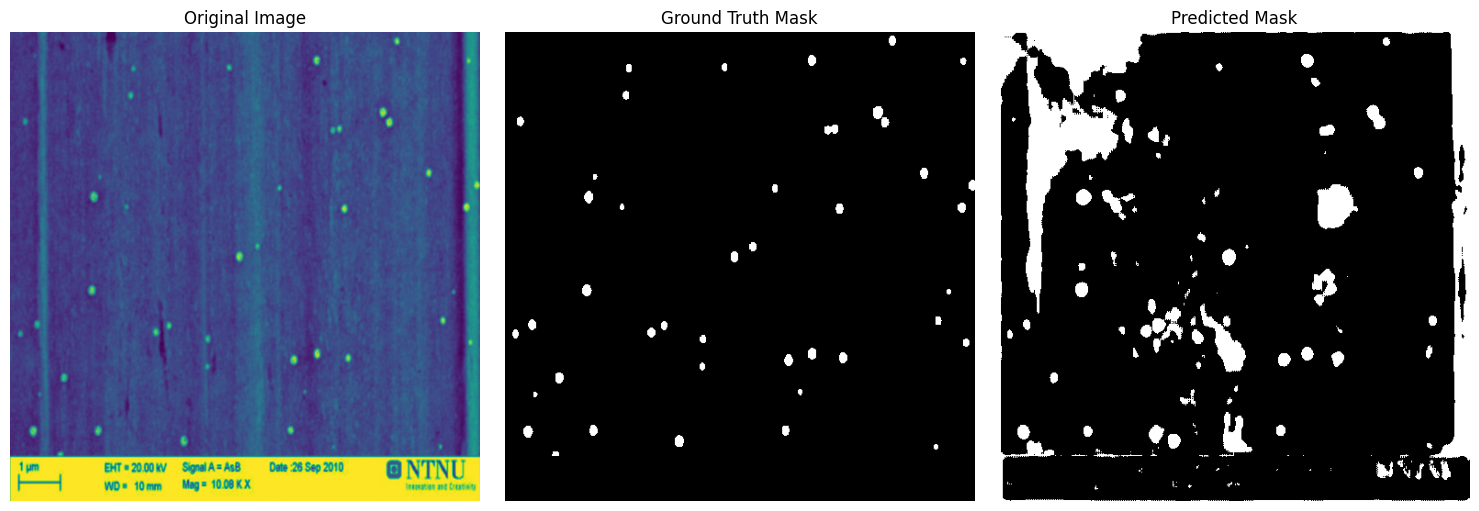

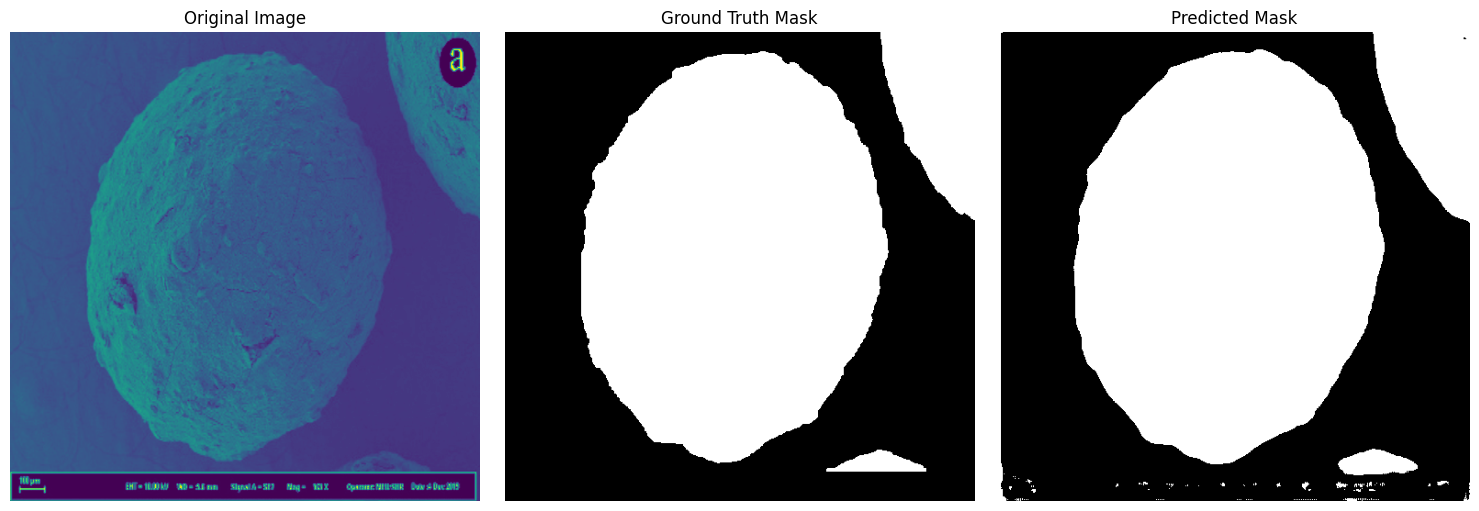

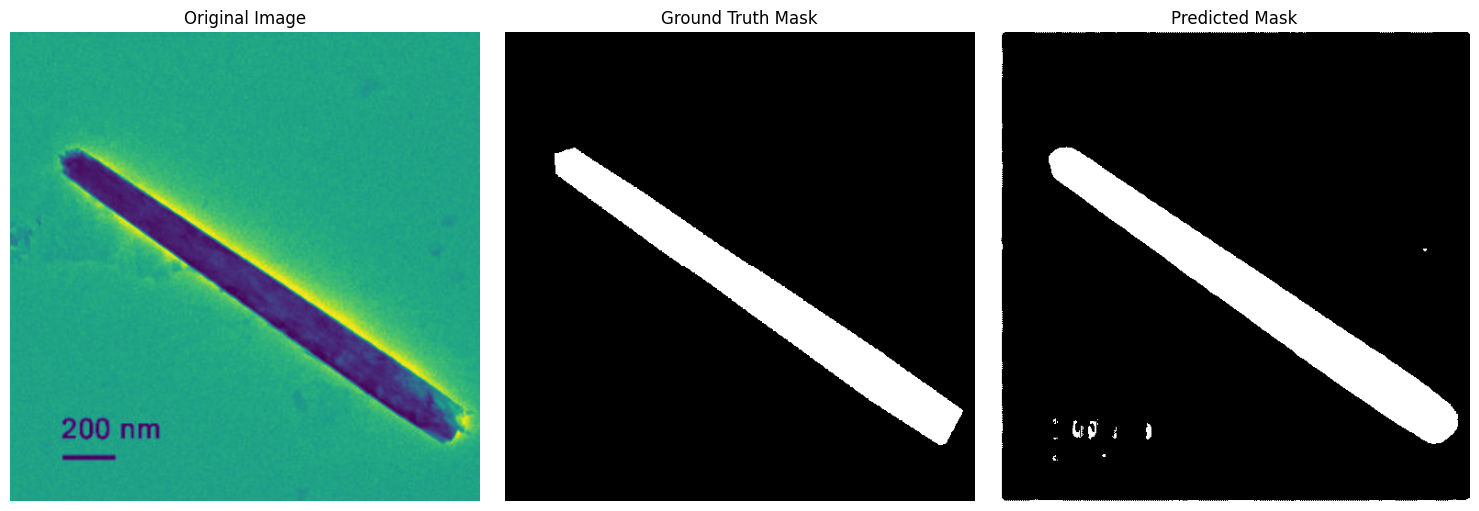

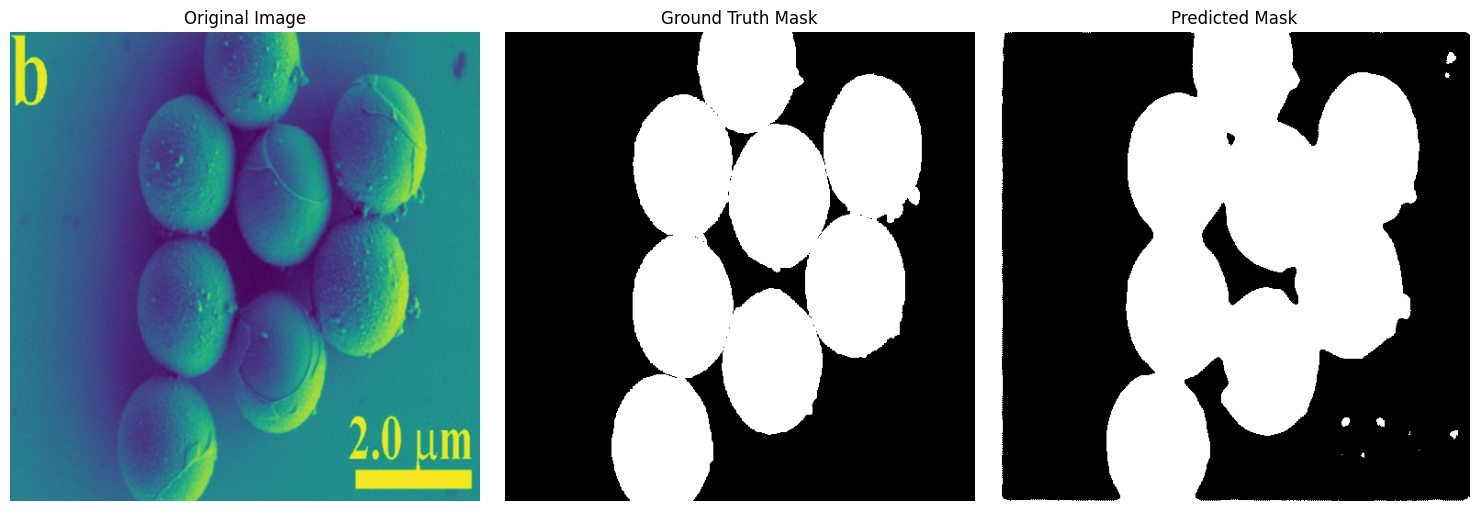

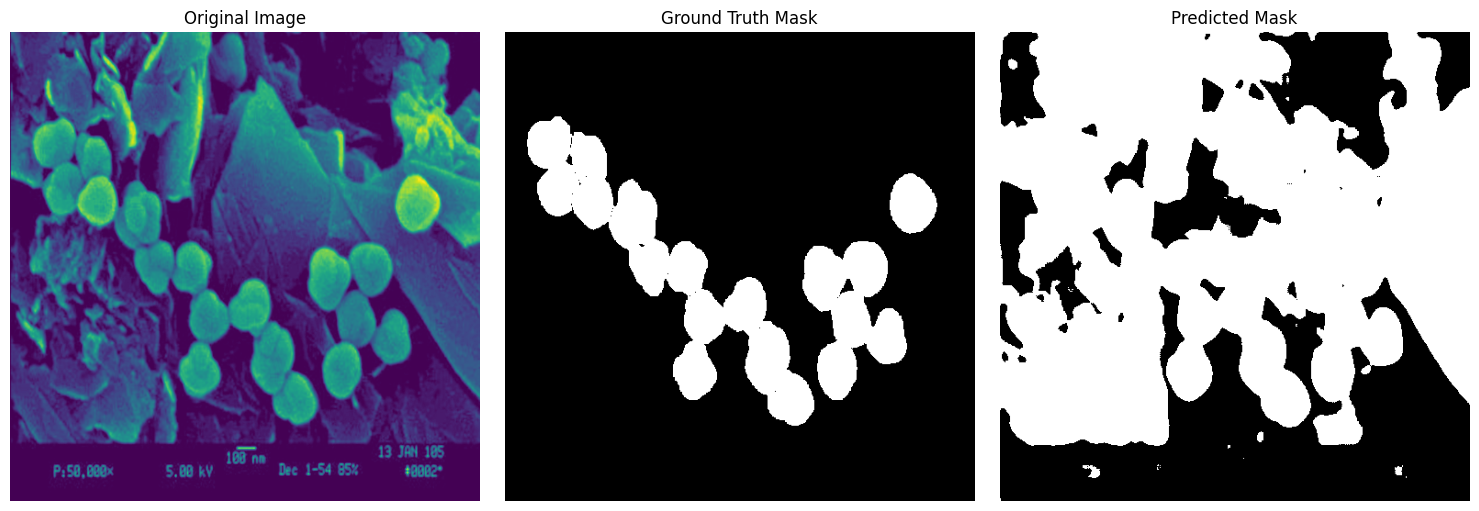

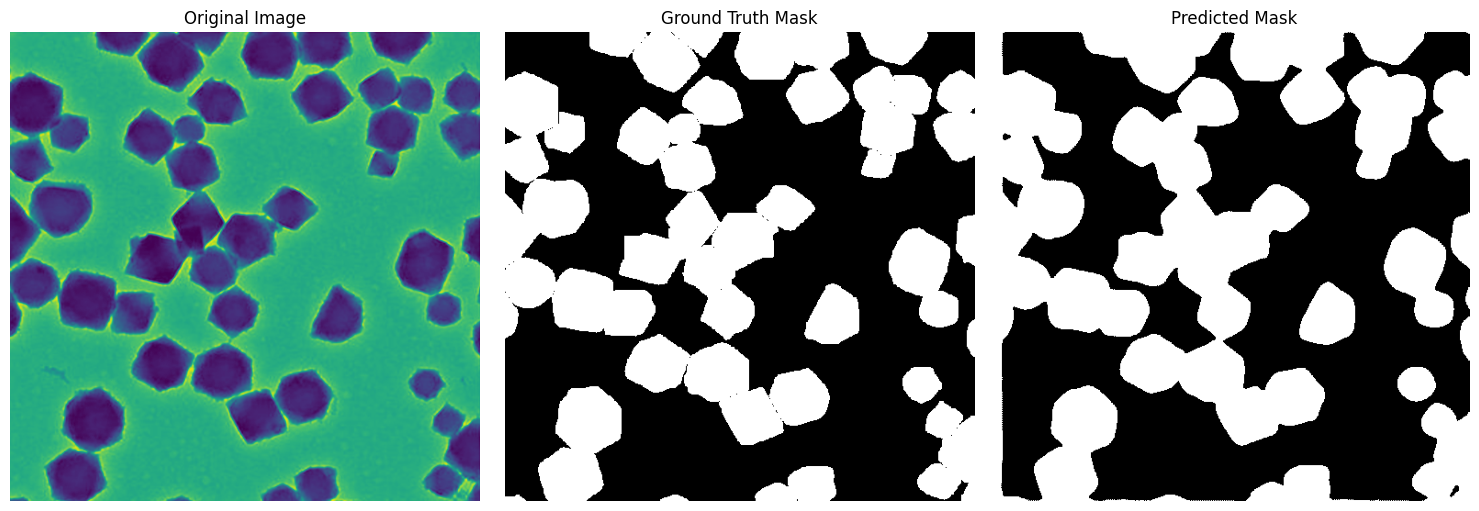

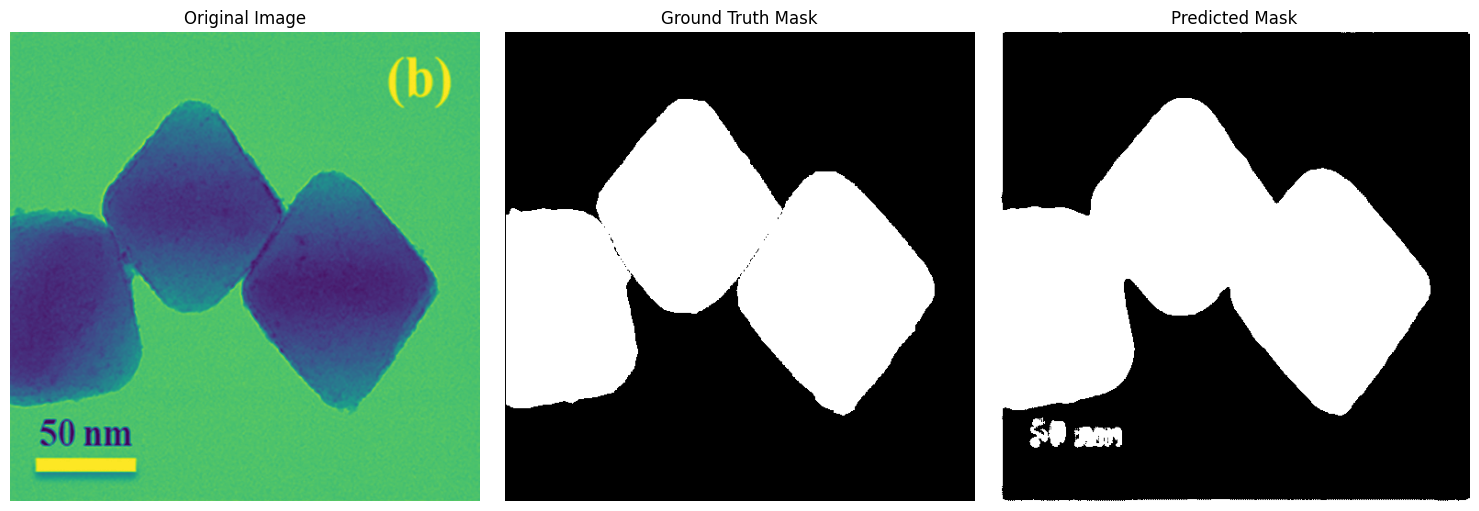

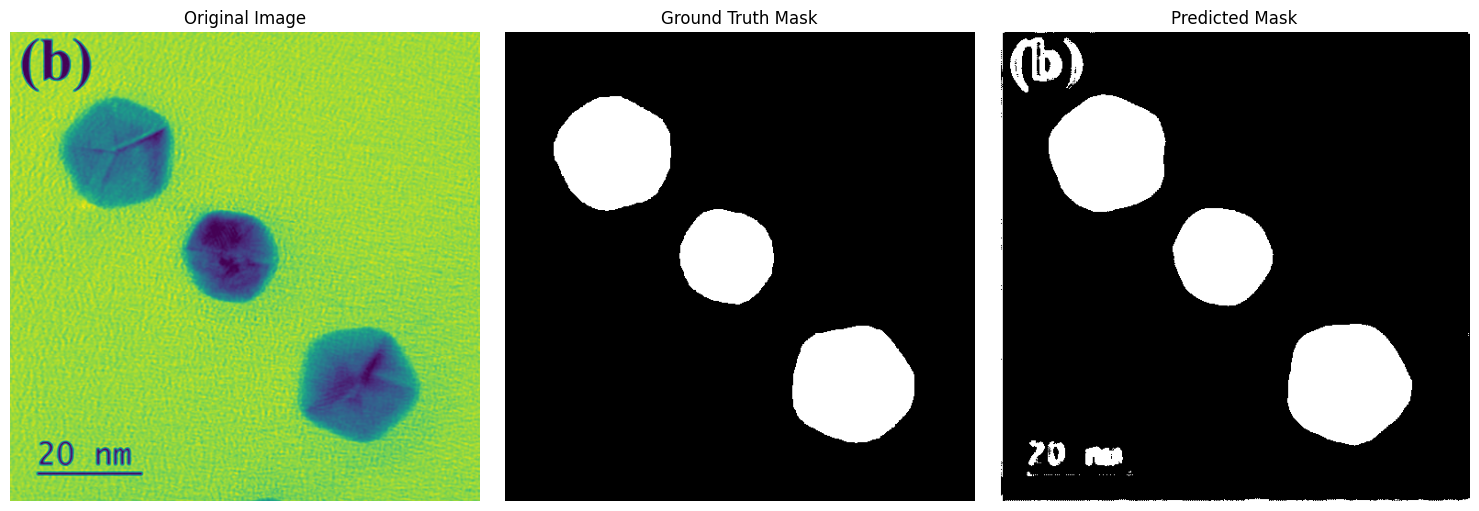

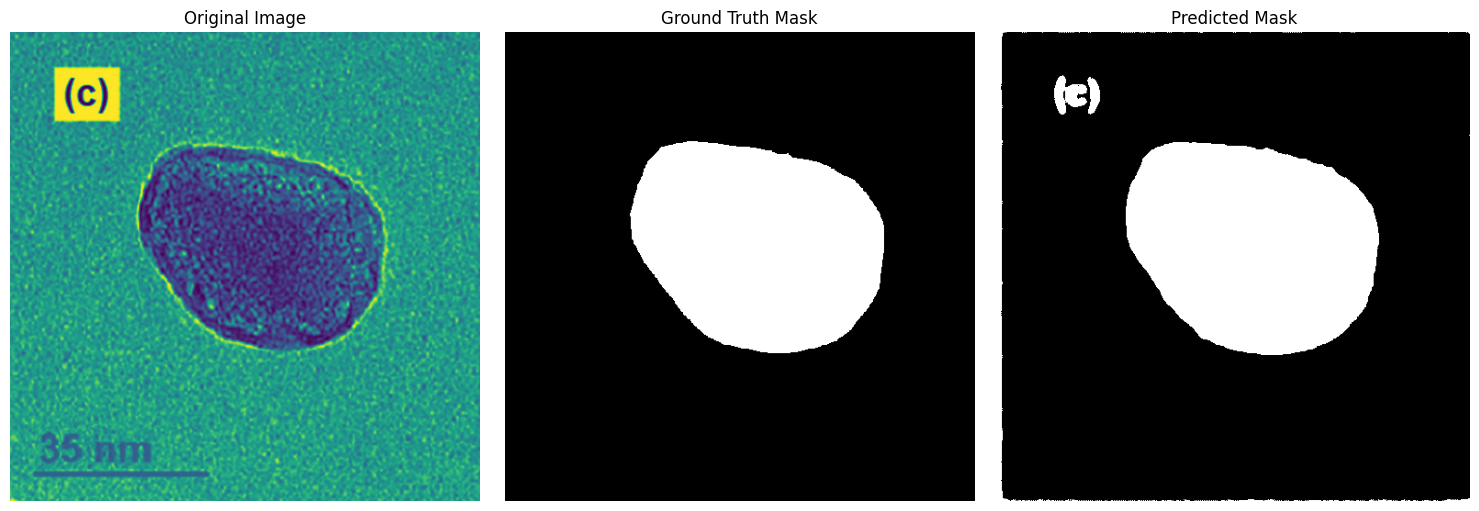

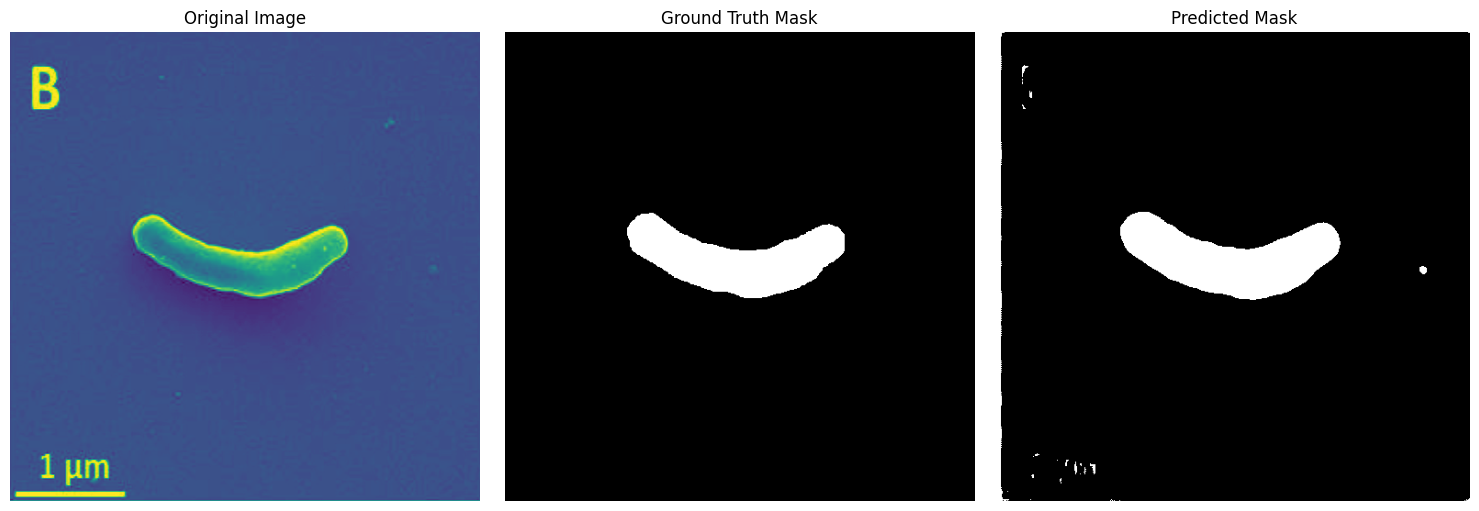

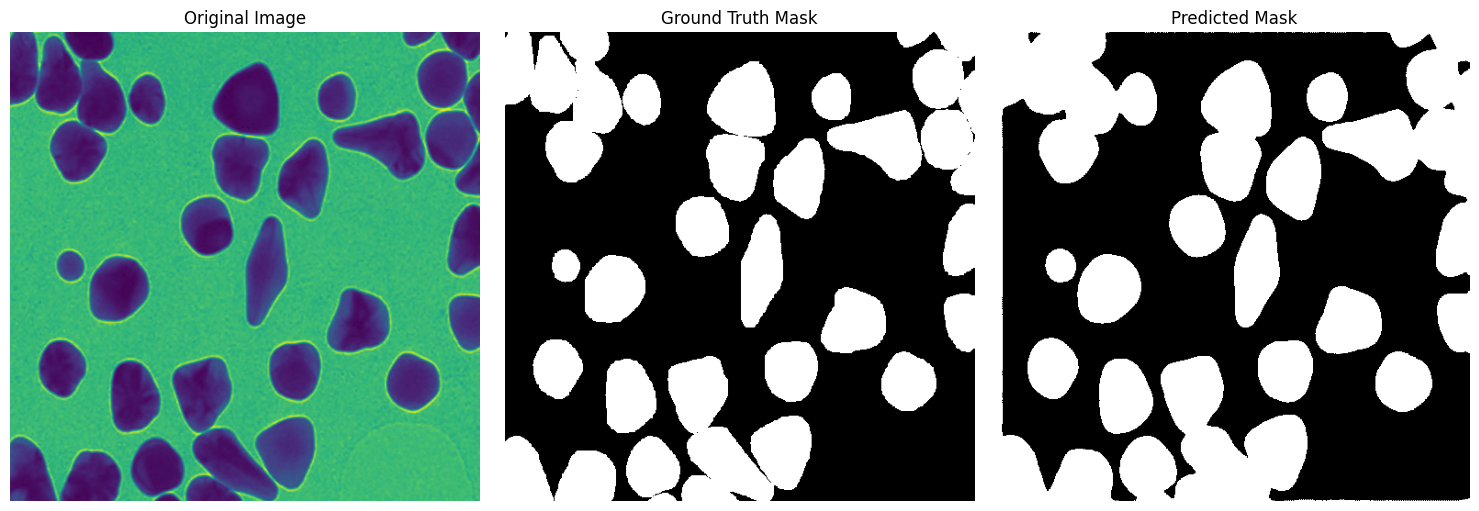

In [38]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    #img = img * std + mean  # Denormalize
    #img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    #plt.savefig(f"epoch_{epoch+1}_image_{i}.png")
    plt.tight_layout()
    plt.show()


In [39]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)

    epoch  train_loss  val_loss  precision    recall  accuracy       iou  \
0       1    0.573396  0.602345   0.320135  1.000000  0.320135  0.317569   
1       2    0.568156  0.600215   0.320315  0.999922  0.320724  0.317724   
2       3    0.553380  0.565790   0.411033  0.951911  0.547945  0.402088   
3       4    0.504241  0.430185   0.737881  0.984297  0.883037  0.720595   
4       5    0.474319  0.479579   0.771534  0.985875  0.902019  0.758319   
5       6    0.458502  0.508217   0.776188  0.996019  0.906783  0.764738   
6       7    0.443992  0.492208   0.787935  0.990889  0.911707  0.775240   
7       8    0.433408  0.481957   0.818618  0.990664  0.926741  0.806405   
8       9    0.423117  0.463600   0.836076  0.988379  0.934242  0.823041   
9      10    0.416187  0.447281   0.825100  0.992164  0.930163  0.814306   
10     11    0.409401  0.461125   0.876662  0.971024  0.946989  0.851963   
11     12    0.400796  0.445505   0.859754  0.985964  0.944018  0.844837   
12     13   